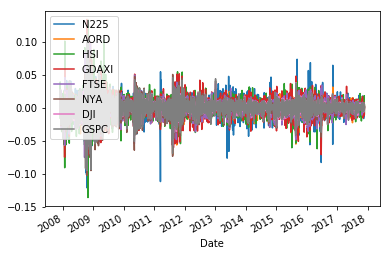

Epoch 	 loss
3000 	 0.627313
6000 	 0.618671
9000 	 0.612706
12000 	 0.612468
15000 	 0.611239


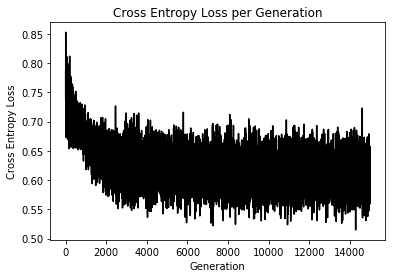

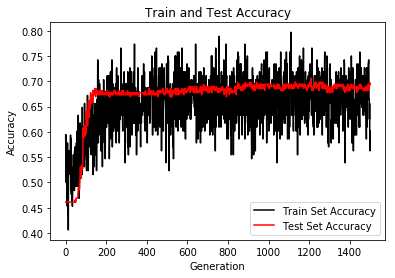

Up_Accuracy	= 0.716814
Down_Accuracy	= 0.674242
Accuracy	= 0.693878
Final_Answer : 1


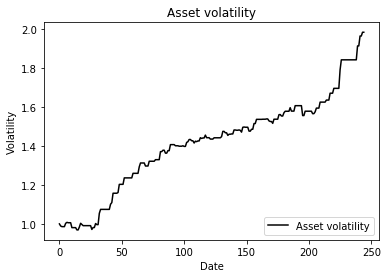

Final_Asset : 1.98388919318 

Epoch 	 loss
3000 	 0.634488
6000 	 0.624323
9000 	 0.61812
12000 	 0.615909
15000 	 0.614875


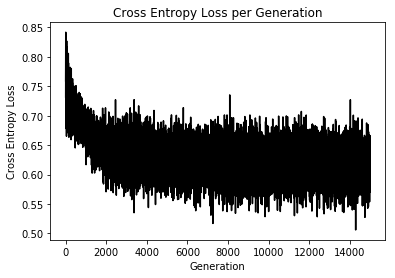

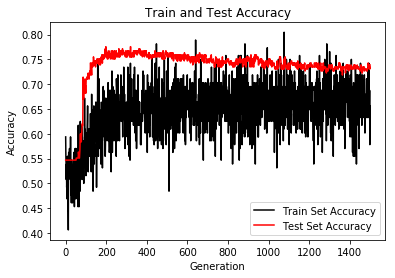

Up_Accuracy	= 0.701493
Down_Accuracy	= 0.783784
Accuracy	= 0.738775
Final_Answer : 0


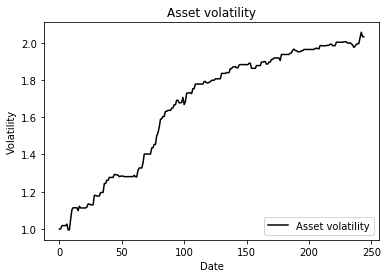

Final_Asset : 2.03250427186 

Epoch 	 loss
3000 	 0.625476
6000 	 0.616948
9000 	 0.611359
12000 	 0.609659
15000 	 0.609768


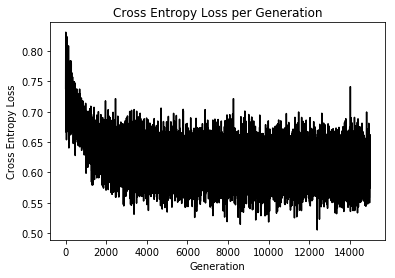

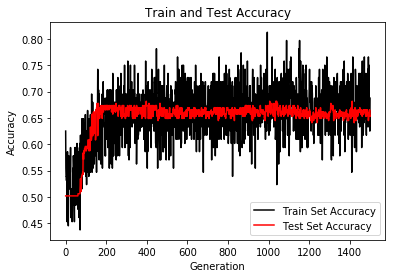

Up_Accuracy	= 0.691057
Down_Accuracy	= 0.614754
Accuracy	= 0.653061
Final_Answer : 1


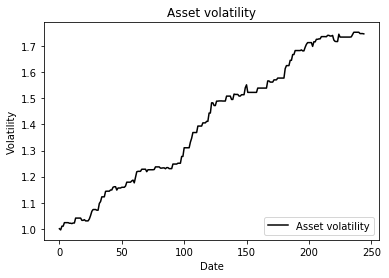

Final_Asset : 1.74737924349 

Epoch 	 loss
3000 	 0.629432
6000 	 0.619982
9000 	 0.614229
12000 	 0.612663
15000 	 0.611885


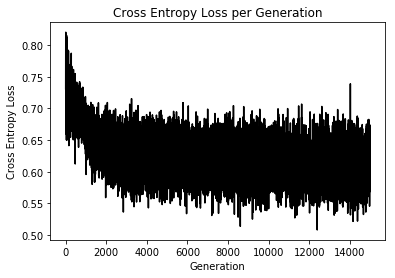

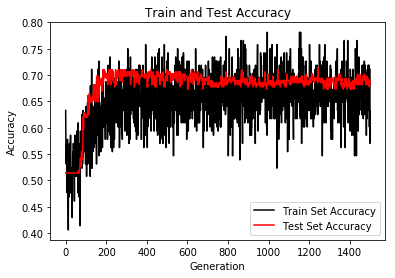

Up_Accuracy	= 0.753968
Down_Accuracy	= 0.613445
Accuracy	= 0.685714
Final_Answer : 1


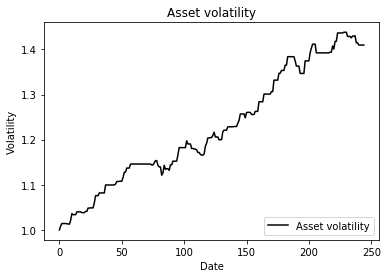

Final_Asset : 1.40961727851 

Epoch 	 loss
3000 	 0.625937
6000 	 0.61712
9000 	 0.61177
12000 	 0.610033
15000 	 0.610498


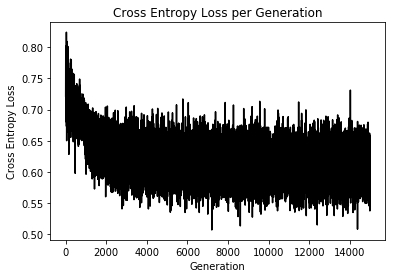

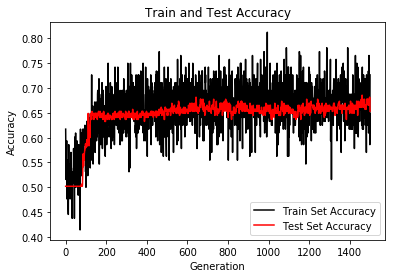

Up_Accuracy	= 0.715447
Down_Accuracy	= 0.590164
Accuracy	= 0.653061
Final_Answer : 1


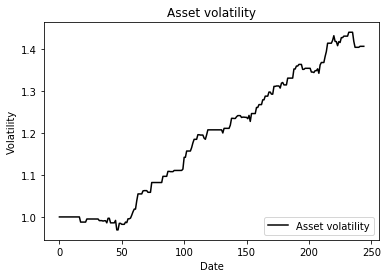

Final_Asset : 1.40752223674 

Epoch 	 loss
3000 	 0.624291
6000 	 0.61464
9000 	 0.609803
12000 	 0.607143
15000 	 0.607407


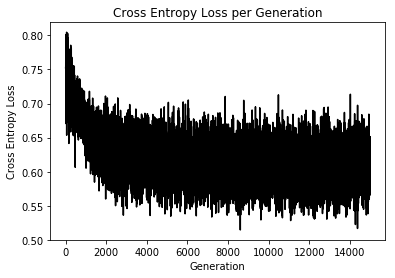

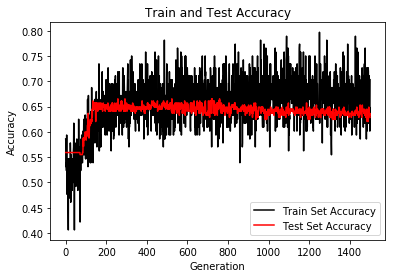

Up_Accuracy	= 0.70073
Down_Accuracy	= 0.537037
Accuracy	= 0.628571
Final_Answer : 1


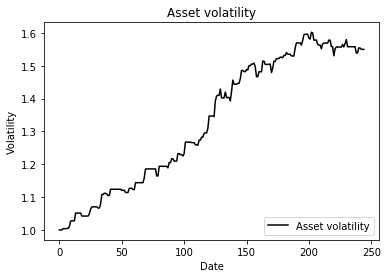

Final_Asset : 1.55021763044 

Epoch 	 loss
3000 	 0.625533
6000 	 0.616965
9000 	 0.612195
12000 	 0.609407
15000 	 0.609557


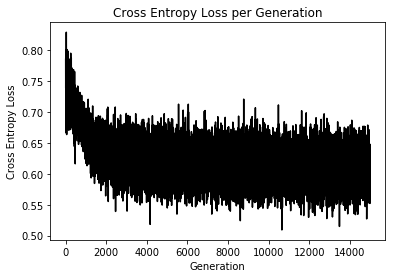

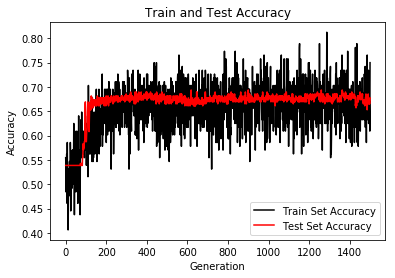

Up_Accuracy	= 0.742424
Down_Accuracy	= 0.60177
Accuracy	= 0.677551
Final_Answer : 1


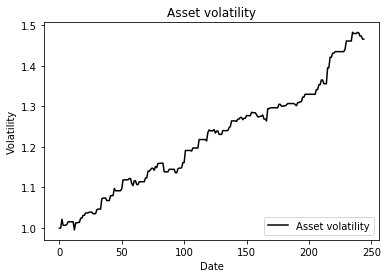

Final_Asset : 1.46540667483 

Epoch 	 loss
3000 	 0.620923
6000 	 0.613298
9000 	 0.608652
12000 	 0.605859
15000 	 0.605676


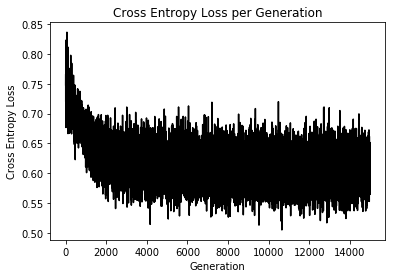

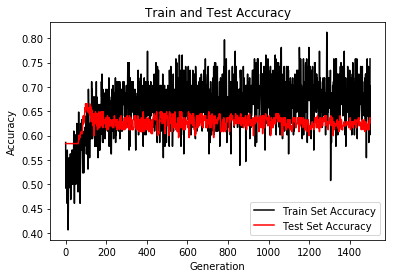

Up_Accuracy	= 0.664336
Down_Accuracy	= 0.598039
Accuracy	= 0.636735
Final_Answer : 0


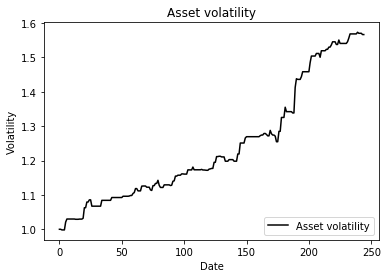

Final_Asset : 1.5666932724 

Epoch 	 loss
3000 	 0.619275
6000 	 0.610911
9000 	 0.608465
12000 	 0.60454
15000 	 0.603698
18000 	 0.601976
21000 	 0.598863
24000 	 0.597308
27000 	 0.597286
30000 	 0.596155


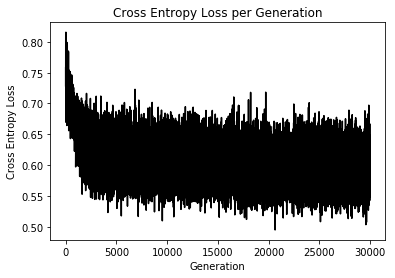

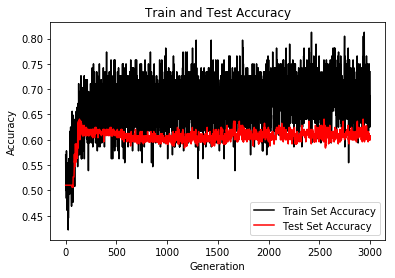

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from model import Model

# ダウンロードしてきたやつ
INDEIES = ["N225",
           "AORD",
           "HSI",
           "GDAXI",
           "FTSE",
           "NYA",
           "DJI",
           "GSPC",
          ]
ANSWER = "N225"

def getClosing():
    closing = pd.DataFrame()
    for index in INDEIES:
        # na_valuesは文字列"null"のとき空として扱う
        df = pd.read_csv("../data/input5/" + index + ".csv", na_values=["null"])
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date")
        closing[index] = df["Close"]
        if index is ANSWER:
            closing["LH"] = (df["Close"].shift()-df["Low"])*(df["High"]-df["Close"].shift())
    # 空の部分は古いので埋める
    closing = closing.fillna(method="ffill")
    LH = np.array(closing["LH"])
    del closing["LH"]
    for index in INDEIES:
        #closing[index] = closing[index] / max(closing[index])
        closing[index] = np.log(closing[index] / closing[index].shift())
    #グラフ表示
    closing.plot()
    plt.show()
    closing["negative"] = 0
    # closing[ANSWER] < 0 の行のnegativeに 1
    closing.loc[closing[ANSWER] < 0, "negative"] = 1
    closing["positive"] = 0
    # closing[ANSWER] >= 0 の行のpositiveに 1
    closing.loc[closing[ANSWER] >= 0, "positive"] = 1
    return closing, LH

def getTraningData():
    closing, LH = getClosing()
    # 1~3日前のデータを予測に使う
    days_before = range(1,4)
    answers = pd.DataFrame(columns = ["negative", "positive"])
    columns = []
    for index in INDEIES:
        columns += [index + "_" + str(before) for before in days_before]
    features = pd.DataFrame(columns = columns)
    for i in range(4, len(closing)):
        # 予測の部分は当日のデータ
        answers = answers.append({
            "negative" : closing["negative"].iloc[i],
            "positive" : closing["positive"].iloc[i]}, ignore_index=True)
        data={}
        # ほかの指標は１個前のデータ
        for index in INDEIES:
            for before in days_before :
                data[index + "_" + str(before)] = closing[index].iloc[i - before]
        features = features.append(data, ignore_index=True)
    for i in days_before :
        drop_col = ANSWER+"_"+str(i)
        #del features[drop_col] # 予測するデータの過去データを入れないとき
    # 予測する元のデータ , 予測するべきデータ
    return features, answers, LH

if __name__ == "__main__":
    start = time.time()
    features, answers, LH = getTraningData()
    for test in range(0,10):
        layers = [50,25]
        model = Model(features,answers,layers,test*0.1,test*0.1+0.1)
        model.train()
        model.test()
        model.value(ANSWER+"_1", LH)
    print("elapsed_time :", time.time()-start, "[sec]")